In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

from analysis import *

import sys
sys.path.insert(0, '../') 
from dl_spectral_normalization.models import alexnet as model
from get_cifar10 import get_cifar10_dataset

%matplotlib inline

In [3]:
Xtr, Ytr, Xtt, Ytt = get_cifar10_dataset(0, n_samps=50000)
_, Ytr_rand, _, Ytt_rand = get_cifar10_dataset(100, n_samps=50000)
val_set = {'X': Xtt[:500], 'Y': Ytt[:500]}
Xtt, Ytt = Xtt[500:], Ytt[500:]
beta_list = np.array([np.inf, 1.0, 1.3, 1.6, 2.0, 4.0])
arch = model.alexnet_sn
C2 = np.mean([np.sqrt(np.sum(np.square(i))) for i in Xtr])
eps = 0.05*C2

dirname_true = '/data/save_weights_tf1.10.1/cifar10/alexnet/'
dirname_rand = '/data/save_weights_tf1.10.1/cifar10/alexnet_randlabels/'

In [4]:
def run_exp(defense, resultsfile, eps=0.3, mode=1, extra_correction=False):
    if os.path.isfile(resultsfile):
        all_margins_true, all_gammas_true, all_margins_rand, all_gammas_rand = \
            pickle.load(file(resultsfile, 'rb'))
    else:
        all_margins_true, all_gammas_true = compute_margins(Xtr, Ytr, dirname_true, beta_list,
                                                            defense, mode=mode, eps=eps,
                                                            extra_correction=extra_correction)
        all_margins_rand, all_gammas_rand = compute_margins(Xtr, Ytr_rand, dirname_rand, beta_list,
                                                            defense, mode=mode, eps=eps,
                                                            extra_correction=extra_correction)
        pickle.dump((all_margins_true, all_gammas_true, all_margins_rand, all_gammas_rand),
                    file(resultsfile, 'wb'))
    return all_margins_true, all_gammas_true, all_margins_rand, all_gammas_rand

        
def plot_hists(data, title=None, value_name=None, legend=True, add_markers=False):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    markers = ['s', 'D', 'v', 'o', '*', '^', '+', '.']
    df = pd.DataFrame.from_dict(data)
    for i, label in enumerate(sorted(df.columns, reverse=True)):
        ax = sns.distplot(df[label], rug=False)
        if add_markers:
            x = ax.lines[2*i].get_xdata()
            y = ax.lines[2*i].get_ydata()
            plt.plot(x[np.argmax(y)], np.max(y), marker=markers[i], markeredgecolor='k', 
                     color=colors[i], label=label)
    plt.xlabel('data' if value_name is None else value_name)
    if title is not None:
        plt.title(title)
    if legend: plt.legend()         

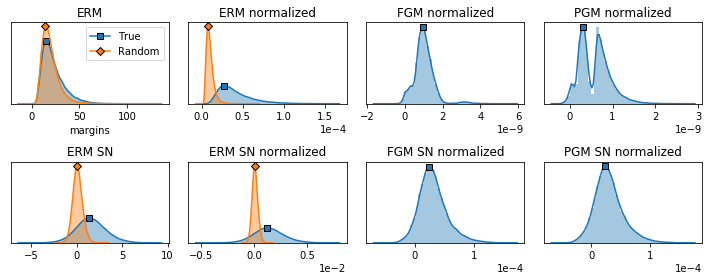

In [5]:
plt.figure(figsize=(10, 4))


# First column: ERM with/without SN, no margin normalization

resultsfile = '/data/save_weights_tf1.10.1/results/marginplots_results_cifar10_alexnet_erm_mode0.pickle'
results = run_exp('erm', resultsfile, mode=0)
margins_true = {beta_list[i]:results[0][i] for i in range(len(beta_list))}
margins_rand = {beta_list[i]:results[2][i] for i in range(len(beta_list))}

plt.subplot(2, 4, 1)
beta = np.inf
data = {'True': margins_true[beta], 'Random': margins_rand[beta]}
plot_hists(data, value_name='margins', add_markers=True)
plt.title('ERM')
plt.yticks([])
# plt.xticks([])
plt.grid(False)

plt.subplot(2, 4, 5)
beta = 1.3
data = {'True': margins_true[beta], 'Random': margins_rand[beta]}
plot_hists(data, value_name='margins', add_markers=True, legend=False)
plt.title('ERM SN')
plt.xlabel('')
plt.yticks([])
# plt.xticks([])
plt.grid(False)


# Second column: ERM with/without SN, margin normalization

resultsfile = '/data/save_weights_tf1.10.1/results/marginplots_results_cifar10_alexnet_erm_mode1_extra_correction.pickle'
results = run_exp('erm', resultsfile, mode=1, extra_correction=True)
margins_true = {beta_list[i]:results[0][i] for i in range(len(beta_list))}
margins_rand = {beta_list[i]:results[2][i] for i in range(len(beta_list))}

plt.subplot(2, 4, 2)
beta = np.inf
data = {'True': margins_true[beta], 'Random': margins_rand[beta]}
plot_hists(data, value_name='margins', add_markers=True, legend=False)
plt.yticks([])
plt.title('ERM normalized')
plt.xlabel('')
plt.grid(False)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.subplot(2, 4, 6)
beta = 1.3
data = {'True': margins_true[beta], 'Random': margins_rand[beta]}
plot_hists(data, value_name='margins', add_markers=True, legend=False)
plt.yticks([])
plt.title('ERM SN normalized')
plt.xlabel('')
plt.grid(False)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))


# Third column: FGM with/without SN, margin normalization

resultsfile = '/data/save_weights_tf1.10.1/results/marginplots_results_cifar10_alexnet_fgm_mode2_extra_correction.pickle'
results = run_exp('fgm', resultsfile, mode=2, extra_correction=True)
margins_true = {beta_list[i]:results[0][i] for i in range(len(beta_list))}

plt.subplot(2, 4, 3)
beta = np.inf
data = {'True': margins_true[beta]}
plot_hists(data, value_name='margins', add_markers=True, legend=False)
plt.title('FGM normalized')
plt.xlabel('')
plt.yticks([])
plt.grid(False)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.subplot(2, 4, 7)
beta = 1.6
data = {'True': margins_true[beta]}
plot_hists(data, value_name='margins', add_markers=True, legend=False)
plt.title('FGM SN normalized')
plt.xlabel('')
plt.yticks([])
plt.grid(False)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))


# Fourth column: PGM with/without SN, margin normalization

resultsfile = '/data/save_weights_tf1.10.1/results/marginplots_results_cifar10_alexnet_pgm_mode2_extra_correction.pickle'
results = run_exp('pgm', resultsfile, mode=2, eps=eps, extra_correction=True)
margins_true = {beta_list[i]:results[0][i] for i in range(len(beta_list))}

plt.subplot(2, 4, 4)
beta = np.inf
data = {'True': margins_true[beta]}
plot_hists(data, value_name='margins', add_markers=True, legend=False)
plt.title('PGM normalized')
plt.xlabel('')
plt.yticks([])
plt.grid(False)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.subplot(2, 4, 8)
beta = 1.6
data = {'True': margins_true[beta]}
plot_hists(data, value_name='margins', add_markers=True, legend=False)
plt.title('PGM SN normalized')
plt.xlabel('')
plt.yticks([])
plt.grid(False)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.tight_layout()
plt.savefig('/data/Figures/cifar10_alexnet_margins.pdf', format='pdf', dpi=500, bbox_inches='tight')
plt.show()